# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

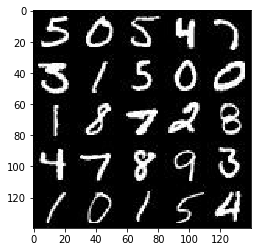

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

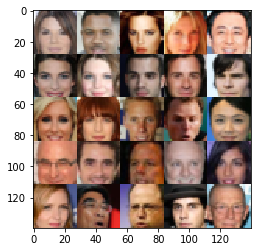

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # LRelu alpha
    alpha = .2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # LRelu alpha
    alpha = .2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Dense layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)
        ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)
        ))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)
        ))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every=10
    show_every=100
    
    # Build model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2571... Generator Loss: 1.8739
Epoch 1/2... Discriminator Loss: 0.1206... Generator Loss: 2.5781
Epoch 1/2... Discriminator Loss: 0.0724... Generator Loss: 3.1701
Epoch 1/2... Discriminator Loss: 0.0384... Generator Loss: 3.7765
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 4.2831
Epoch 1/2... Discriminator Loss: 0.0172... Generator Loss: 4.4365
Epoch 1/2... Discriminator Loss: 0.0135... Generator Loss: 4.7480
Epoch 1/2... Discriminator Loss: 0.0444... Generator Loss: 3.4810
Epoch 1/2... Discriminator Loss: 0.0192... Generator Loss: 4.5357
Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 4.9628


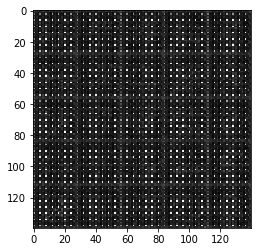

Epoch 1/2... Discriminator Loss: 0.0084... Generator Loss: 5.3838
Epoch 1/2... Discriminator Loss: 0.0079... Generator Loss: 5.5676
Epoch 1/2... Discriminator Loss: 0.0056... Generator Loss: 5.6853
Epoch 1/2... Discriminator Loss: 0.0051... Generator Loss: 5.7793
Epoch 1/2... Discriminator Loss: 0.0041... Generator Loss: 5.8911
Epoch 1/2... Discriminator Loss: 0.0154... Generator Loss: 4.4663
Epoch 1/2... Discriminator Loss: 0.0998... Generator Loss: 3.0835
Epoch 1/2... Discriminator Loss: 0.0344... Generator Loss: 4.5124
Epoch 1/2... Discriminator Loss: 0.0093... Generator Loss: 5.5964
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 4.5560


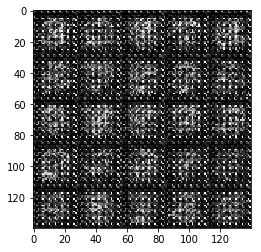

Epoch 1/2... Discriminator Loss: 0.2968... Generator Loss: 2.0066
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 3.1009
Epoch 1/2... Discriminator Loss: 2.0660... Generator Loss: 0.4400
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 1.4244
Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 1.8100
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 1.4045
Epoch 1/2... Discriminator Loss: 1.0101... Generator Loss: 1.5799
Epoch 1/2... Discriminator Loss: 0.8249... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 0.9872


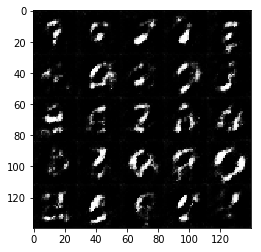

Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.3433
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 0.9918... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 1.4013
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 0.6908... Generator Loss: 1.1941


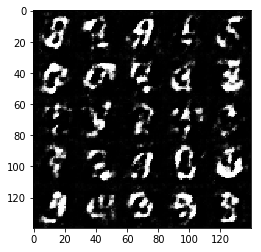

Epoch 1/2... Discriminator Loss: 0.6561... Generator Loss: 1.2740
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.5010
Epoch 1/2... Discriminator Loss: 0.7087... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.7244
Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 1.2849
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 2.0613
Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 1.6683
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 1.0689
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 0.9332


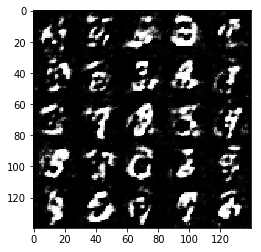

Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 1.5625
Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 1.2164
Epoch 1/2... Discriminator Loss: 0.6005... Generator Loss: 1.8439
Epoch 1/2... Discriminator Loss: 0.4599... Generator Loss: 1.6718
Epoch 1/2... Discriminator Loss: 0.6061... Generator Loss: 1.1765
Epoch 1/2... Discriminator Loss: 0.4740... Generator Loss: 1.6053
Epoch 1/2... Discriminator Loss: 0.4260... Generator Loss: 1.6123
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 1.2229
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 1.4463


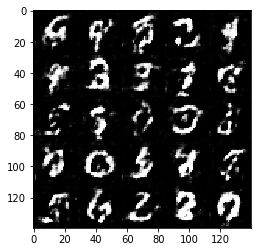

Epoch 1/2... Discriminator Loss: 0.3293... Generator Loss: 1.9660
Epoch 1/2... Discriminator Loss: 0.4250... Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 0.3704... Generator Loss: 1.9388
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 2.1562
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 1.2718
Epoch 1/2... Discriminator Loss: 0.3598... Generator Loss: 1.6138
Epoch 1/2... Discriminator Loss: 0.5737... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 1.3449
Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 2.2949
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 1.4116


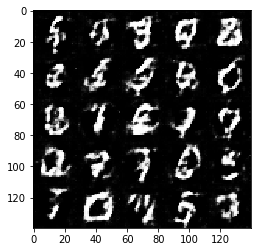

Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 1.6421
Epoch 1/2... Discriminator Loss: 0.3097... Generator Loss: 1.8528
Epoch 1/2... Discriminator Loss: 0.2939... Generator Loss: 2.1379
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 1.9833
Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 1.5679
Epoch 1/2... Discriminator Loss: 0.4630... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 0.4370... Generator Loss: 1.7421
Epoch 1/2... Discriminator Loss: 1.5548... Generator Loss: 0.3290
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 1.8940
Epoch 1/2... Discriminator Loss: 0.4900... Generator Loss: 1.3601


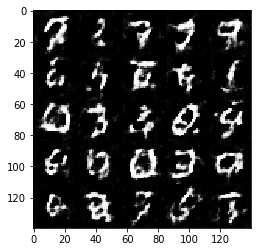

Epoch 1/2... Discriminator Loss: 0.5098... Generator Loss: 1.3027
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 2.2723
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 1.4451
Epoch 1/2... Discriminator Loss: 0.6577... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 1.4131
Epoch 1/2... Discriminator Loss: 0.5658... Generator Loss: 1.5218


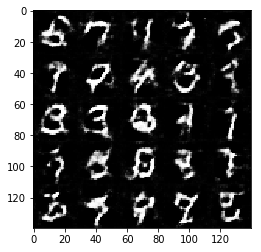

Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.8985
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.5344
Epoch 2/2... Discriminator Loss: 0.6707... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 1.9501
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.1359


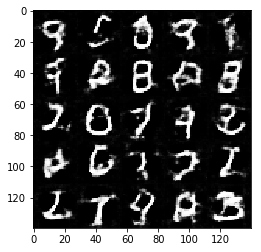

Epoch 2/2... Discriminator Loss: 0.7466... Generator Loss: 1.7000
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.2739
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.7706
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.2494


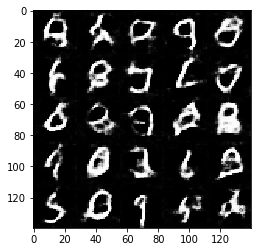

Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.5232
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.8690
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.2792
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 1.5499
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 2.1236
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.1080


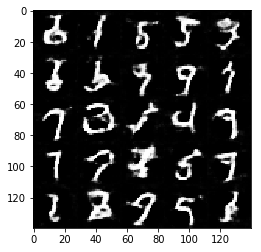

Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 0.6221... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.6641
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 1.4131
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 1.6065
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 0.9158


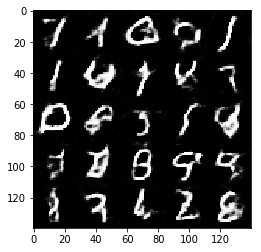

Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.4851
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.9257
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 2.2319
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.1124
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.4731
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.1822


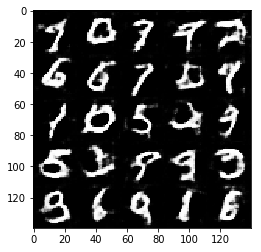

Epoch 2/2... Discriminator Loss: 0.6350... Generator Loss: 1.3566
Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 1.7334
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.1906
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.7199
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.5250
Epoch 2/2... Discriminator Loss: 0.5757... Generator Loss: 1.4563
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.4124


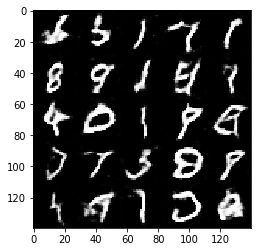

Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 1.6094
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.2986
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 1.8594


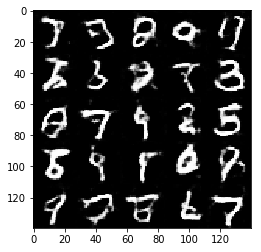

Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.3503
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.9991
Epoch 2/2... Discriminator Loss: 0.7050... Generator Loss: 2.0259
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.5466
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.5919
Epoch 2/2... Discriminator Loss: 0.5720... Generator Loss: 1.6477
Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 1.2674
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 1.5500


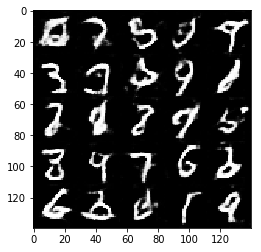

Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.1368
Epoch 2/2... Discriminator Loss: 0.4424... Generator Loss: 1.6959
Epoch 2/2... Discriminator Loss: 0.5064... Generator Loss: 2.6256
Epoch 2/2... Discriminator Loss: 0.4143... Generator Loss: 1.7789
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 1.6157
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.1877... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 2.4287


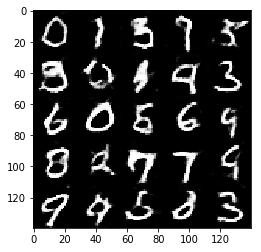

Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.4456
Epoch 2/2... Discriminator Loss: 0.4622... Generator Loss: 1.6651
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 2.8433
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 1.7761
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 0.4856... Generator Loss: 1.7552


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 2.4024
Epoch 1/1... Discriminator Loss: 1.8987... Generator Loss: 0.2116
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 1.9548


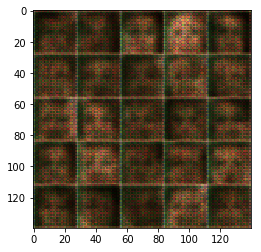

Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.6795
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 0.9727


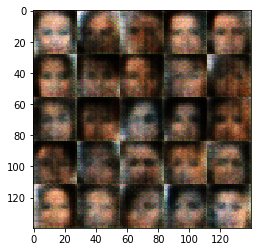

Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 2.3060
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 2.0249
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.1444


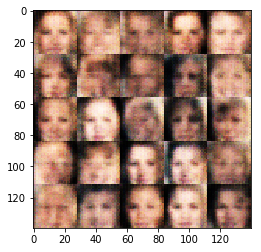

Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.6357
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 2.9327
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.3453


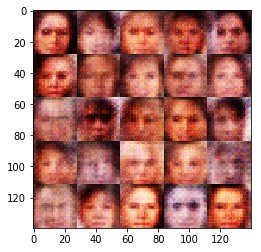

Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.3738
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.5622


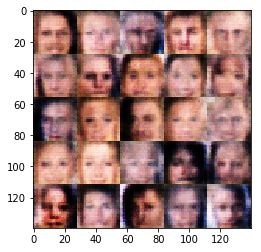

Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.3061
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5395


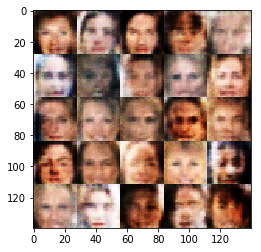

Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9249


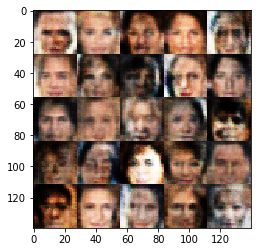

Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.8191


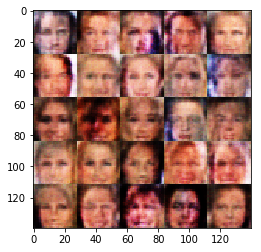

Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5913


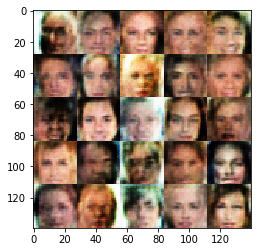

Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.3451
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.5037
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.9436
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7003


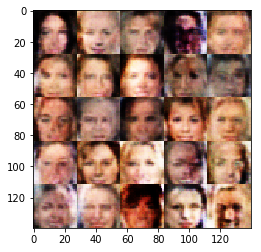

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 2.3380
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.9997
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.8604


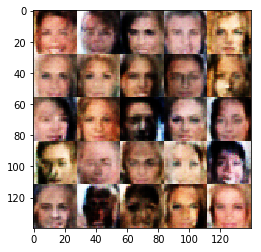

Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.5922
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 2.4022


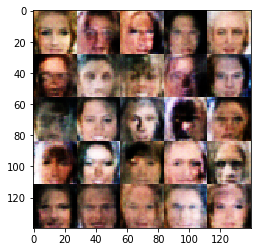

Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 3.7654
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 2.3328
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 3.3436
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.1730
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.3152


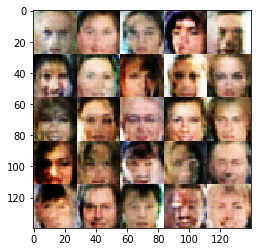

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 2.0947
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 3.6868
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.9367... Generator Loss: 0.2013
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.0638


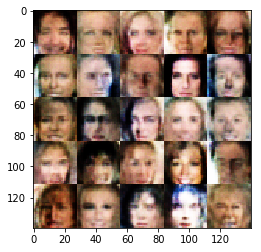

Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 1.9913
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 3.8048
Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 3.5315
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 3.0230
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 2.1668
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 3.9781
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 3.7046
Epoch 1/1... Discriminator Loss: 0.2427... Generator Loss: 2.2920


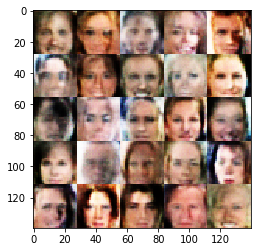

Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 2.1829
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 1.9168
Epoch 1/1... Discriminator Loss: 0.2108... Generator Loss: 3.2559
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 3.0758
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 5.5352
Epoch 1/1... Discriminator Loss: 0.2227... Generator Loss: 2.1787
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 4.1497
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 0.1029... Generator Loss: 3.2365


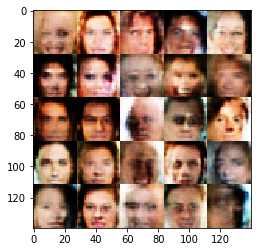

Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 2.9931
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 4.1422
Epoch 1/1... Discriminator Loss: 0.2148... Generator Loss: 2.6890
Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 3.1526
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 6.7633
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.4539


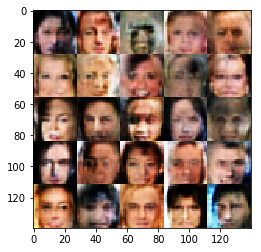

Epoch 1/1... Discriminator Loss: 0.2027... Generator Loss: 2.9993
Epoch 1/1... Discriminator Loss: 0.5635... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 2.6278
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 4.8126
Epoch 1/1... Discriminator Loss: 0.1781... Generator Loss: 3.3811
Epoch 1/1... Discriminator Loss: 0.2356... Generator Loss: 3.0461
Epoch 1/1... Discriminator Loss: 0.0398... Generator Loss: 4.6359
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 2.0211


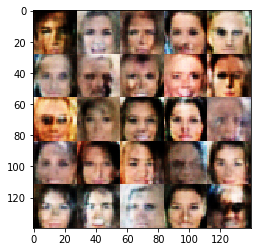

Epoch 1/1... Discriminator Loss: 0.2630... Generator Loss: 2.1845
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 5.5538
Epoch 1/1... Discriminator Loss: 0.1716... Generator Loss: 2.5001
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 1.6218
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 4.0159
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 4.6857
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.8623
Epoch 1/1... Discriminator Loss: 0.2160... Generator Loss: 2.3711
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 2.8177


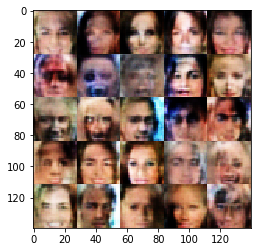

Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 4.5205
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 2.3732
Epoch 1/1... Discriminator Loss: 0.0803... Generator Loss: 3.4348
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 7.4571
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 5.9277
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 3.7778
Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 3.5696
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.8836


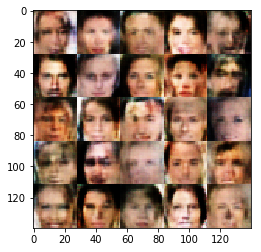

Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 2.2983
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.2101... Generator Loss: 2.1726
Epoch 1/1... Discriminator Loss: 0.0811... Generator Loss: 4.4359
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 5.9138
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 5.3366
Epoch 1/1... Discriminator Loss: 0.2406... Generator Loss: 1.8470
Epoch 1/1... Discriminator Loss: 0.0255... Generator Loss: 6.9184
Epoch 1/1... Discriminator Loss: 0.1412... Generator Loss: 2.9072


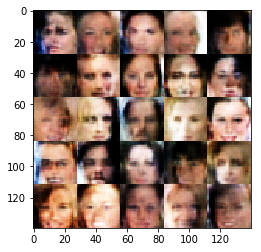

Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 7.9045
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 7.3132
Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 4.6291
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 4.5284
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 1.9728
Epoch 1/1... Discriminator Loss: 0.2191... Generator Loss: 2.0967
Epoch 1/1... Discriminator Loss: 0.1522... Generator Loss: 7.2901
Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 4.0421
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 7.2929


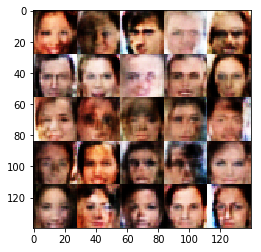

Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 8.7833
Epoch 1/1... Discriminator Loss: 2.7995... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 2.7688
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 2.0272
Epoch 1/1... Discriminator Loss: 0.2705... Generator Loss: 6.6723
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 3.2941
Epoch 1/1... Discriminator Loss: 0.1658... Generator Loss: 2.3465
Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 3.7997


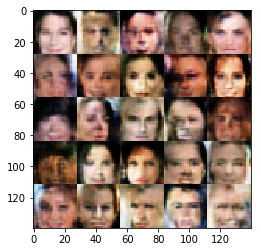

Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 3.1810
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 0.0995... Generator Loss: 2.7968
Epoch 1/1... Discriminator Loss: 0.1464... Generator Loss: 2.4620
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 2.5278
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 3.0887
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 0.0940... Generator Loss: 3.2672


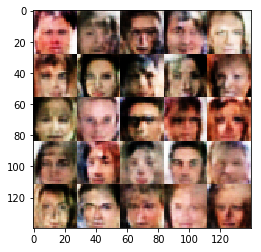

Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 6.9489
Epoch 1/1... Discriminator Loss: 2.2938... Generator Loss: 3.6570
Epoch 1/1... Discriminator Loss: 0.0652... Generator Loss: 3.6991
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 5.0696
Epoch 1/1... Discriminator Loss: 0.1736... Generator Loss: 2.4348
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 7.8442
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 3.3818
Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 4.6927
Epoch 1/1... Discriminator Loss: 0.0636... Generator Loss: 4.5681
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.5299


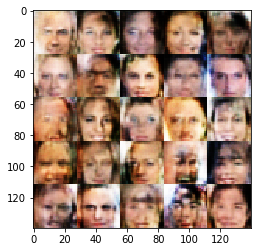

Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 6.9213
Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 3.6535
Epoch 1/1... Discriminator Loss: 0.0896... Generator Loss: 5.3277
Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 7.9707
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 5.3319
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 3.3953
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 3.7296
Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 7.0731


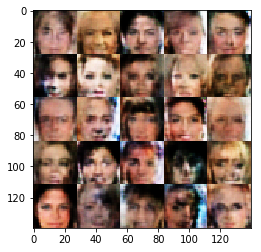

Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 3.6351
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 3.4897
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 4.8492
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.0866... Generator Loss: 6.3986
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 2.2490
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.2104


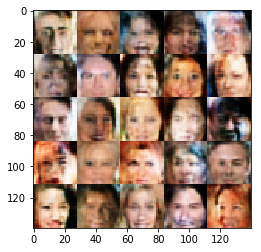

Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 6.1797
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 0.1764... Generator Loss: 2.3809
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 4.0962
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 3.0829
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 2.9620
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 4.1925
Epoch 1/1... Discriminator Loss: 0.2545... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 1.6880


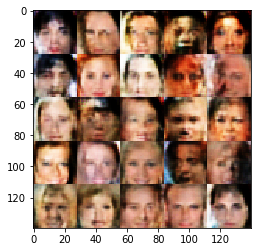

Epoch 1/1... Discriminator Loss: 0.1133... Generator Loss: 2.8354
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 3.1549
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 3.0848
Epoch 1/1... Discriminator Loss: 0.0617... Generator Loss: 4.9875
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 4.1972
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 4.1890
Epoch 1/1... Discriminator Loss: 0.0584... Generator Loss: 5.8782
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 2.0966
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 7.9630
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 4.7601


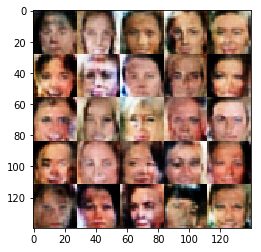

Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.9546
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 4.1549
Epoch 1/1... Discriminator Loss: 0.0721... Generator Loss: 5.9409
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 6.0121
Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 2.8893
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 7.2861
Epoch 1/1... Discriminator Loss: 0.1089... Generator Loss: 4.7223
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 9.3480
Epoch 1/1... Discriminator Loss: 0.0441... Generator Loss: 6.3293


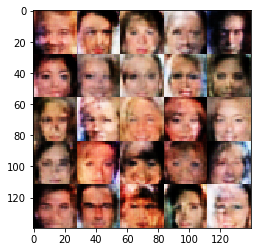

Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 7.2485
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 3.1161
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 5.5607
Epoch 1/1... Discriminator Loss: 0.1029... Generator Loss: 3.5226
Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 7.1989
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 2.4714
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 1.6858
Epoch 1/1... Discriminator Loss: 0.2344... Generator Loss: 2.2547
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 4.6382
Epoch 1/1... Discriminator Loss: 0.2080... Generator Loss: 2.7666


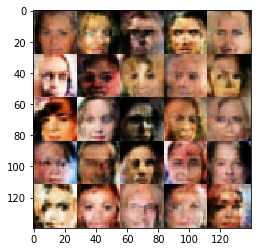

Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 4.9529
Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 7.5995
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 4.0611
Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 4.7058
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 4.3784
Epoch 1/1... Discriminator Loss: 0.1005... Generator Loss: 3.4879
Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 4.1827
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 6.4989
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 5.9703
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 6.5776


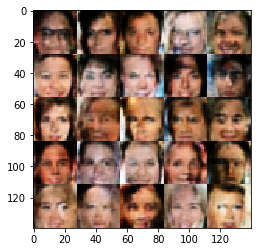

Epoch 1/1... Discriminator Loss: 2.7394... Generator Loss: 0.1037
Epoch 1/1... Discriminator Loss: 0.0561... Generator Loss: 3.6395
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 4.3406
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.2058... Generator Loss: 2.0910
Epoch 1/1... Discriminator Loss: 0.1011... Generator Loss: 2.6317
Epoch 1/1... Discriminator Loss: 0.2917... Generator Loss: 1.8532
Epoch 1/1... Discriminator Loss: 0.2156... Generator Loss: 2.5934
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 6.4483
Epoch 1/1... Discriminator Loss: 0.1139... Generator Loss: 3.0270


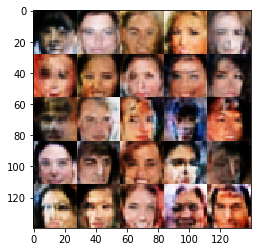

Epoch 1/1... Discriminator Loss: 0.0464... Generator Loss: 4.3073
Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 2.2584
Epoch 1/1... Discriminator Loss: 0.0498... Generator Loss: 4.8794
Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 3.5524
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 4.5453
Epoch 1/1... Discriminator Loss: 0.2178... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 4.8512
Epoch 1/1... Discriminator Loss: 0.0927... Generator Loss: 3.5483
Epoch 1/1... Discriminator Loss: 0.0881... Generator Loss: 3.8669
Epoch 1/1... Discriminator Loss: 2.1136... Generator Loss: 0.2761


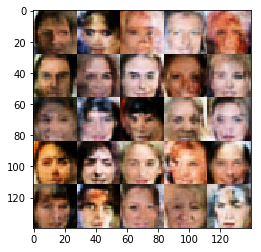

Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 3.8710
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 5.6108
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 1.6451
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.2280
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 4.2267
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 3.5512
Epoch 1/1... Discriminator Loss: 0.1320... Generator Loss: 3.0474
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 3.2471
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 3.2423


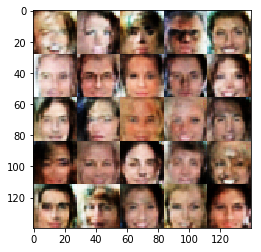

Epoch 1/1... Discriminator Loss: 0.2452... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 4.0723
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 6.6891
Epoch 1/1... Discriminator Loss: 0.1629... Generator Loss: 3.2469
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 4.1625
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 1.5484
Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 5.1001


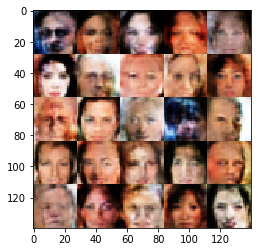

Epoch 1/1... Discriminator Loss: 0.1243... Generator Loss: 2.5937
Epoch 1/1... Discriminator Loss: 0.1214... Generator Loss: 2.9589
Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 4.6855
Epoch 1/1... Discriminator Loss: 0.1718... Generator Loss: 2.2476
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 8.3092
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 4.7694
Epoch 1/1... Discriminator Loss: 0.3074... Generator Loss: 1.6072
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 5.0861
Epoch 1/1... Discriminator Loss: 0.0953... Generator Loss: 3.6475
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 3.3263


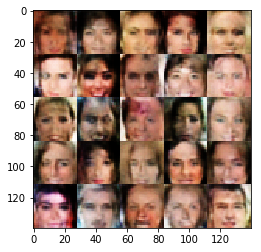

Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 2.7647
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.8372
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 2.8112
Epoch 1/1... Discriminator Loss: 0.2563... Generator Loss: 2.0099
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.3481
Epoch 1/1... Discriminator Loss: 3.3424... Generator Loss: 0.0563
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 2.3959
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.4384


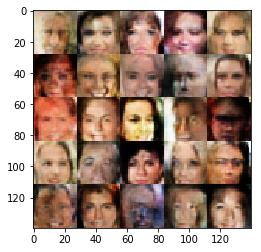

Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 6.5509
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 0.3023... Generator Loss: 1.6816
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.1942... Generator Loss: 2.3784
Epoch 1/1... Discriminator Loss: 2.0835... Generator Loss: 5.9835
Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 5.0128
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.4295


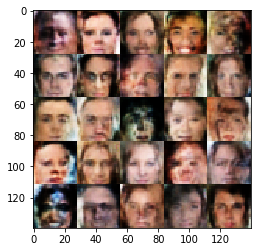

Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 1.9197
Epoch 1/1... Discriminator Loss: 0.2649... Generator Loss: 2.2458
Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 3.6847
Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 4.1918
Epoch 1/1... Discriminator Loss: 0.2267... Generator Loss: 2.3342
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 10.7305
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 5.4876
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 5.0923
Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 3.5145
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 1.1186


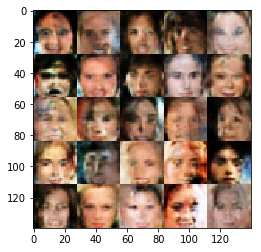

Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 3.2311
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 1.8309
Epoch 1/1... Discriminator Loss: 0.1214... Generator Loss: 3.2770
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 6.2462
Epoch 1/1... Discriminator Loss: 0.0431... Generator Loss: 6.3704
Epoch 1/1... Discriminator Loss: 0.1530... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.2472... Generator Loss: 2.3858
Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 3.0314
Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.4033


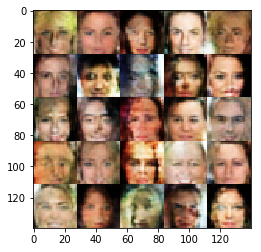

Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.2924
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 3.9244
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 3.1793
Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 5.1475
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 4.5425
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 8.4763
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 4.4537
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 2.2716
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 7.4077
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 6.3540


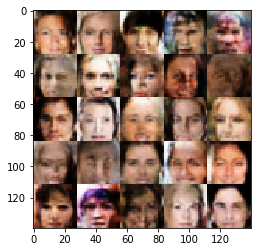

Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 3.2413
Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 2.5895
Epoch 1/1... Discriminator Loss: 0.3205... Generator Loss: 2.9739
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 5.0811
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.5690


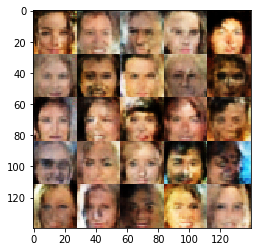

Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 2.7175
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 3.1738
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 2.2765
Epoch 1/1... Discriminator Loss: 0.0803... Generator Loss: 3.7077
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 1.4641
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 2.7117


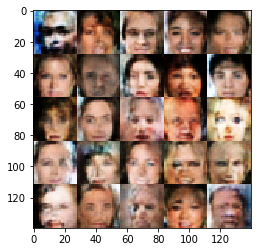

Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 3.9830
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 0.2486... Generator Loss: 2.2793
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 8.8358
Epoch 1/1... Discriminator Loss: 0.1292... Generator Loss: 3.2882
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 1.9047
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 3.8338
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 7.9560
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 1.9850
Epoch 1/1... Discriminator Loss: 0.2604... Generator Loss: 1.8935


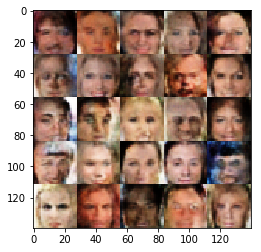

Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 4.2285
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 3.8290
Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 2.3393
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 4.9288
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 7.5136
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 5.9269
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 4.3491
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 9.1487
Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 1.9753
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 0.9023


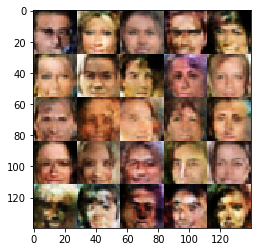

Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 5.1558
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 7.5007
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 2.6879
Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 3.0263
Epoch 1/1... Discriminator Loss: 0.1026... Generator Loss: 3.3910
Epoch 1/1... Discriminator Loss: 0.0817... Generator Loss: 3.9646
Epoch 1/1... Discriminator Loss: 0.3193... Generator Loss: 1.6898
Epoch 1/1... Discriminator Loss: 0.1283... Generator Loss: 2.5659
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 3.4188
Epoch 1/1... Discriminator Loss: 0.1062... Generator Loss: 3.0069


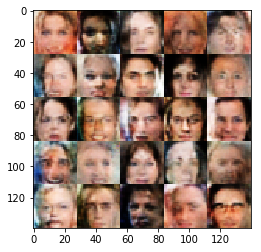

Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 7.6457
Epoch 1/1... Discriminator Loss: 0.1384... Generator Loss: 2.5766
Epoch 1/1... Discriminator Loss: 0.2142... Generator Loss: 6.5717
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 7.5033
Epoch 1/1... Discriminator Loss: 0.2040... Generator Loss: 2.2443
Epoch 1/1... Discriminator Loss: 0.0444... Generator Loss: 7.5685
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 3.8810
Epoch 1/1... Discriminator Loss: 2.5897... Generator Loss: 0.1530
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 2.2154


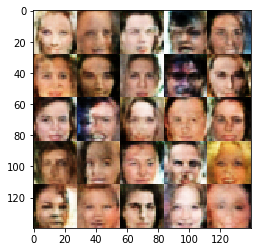

Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 0.2014... Generator Loss: 2.3139
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 5.3366
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 3.6539
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 1.9014
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 2.6362
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 2.9508
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 2.0151
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.5785


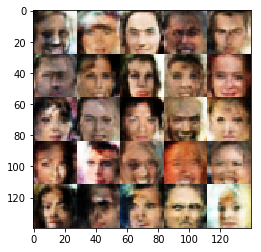

Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 1.9847... Generator Loss: 0.2079
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 3.9168
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 4.0480
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 3.0913
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 3.4067
Epoch 1/1... Discriminator Loss: 0.1442... Generator Loss: 2.3705
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 5.3723


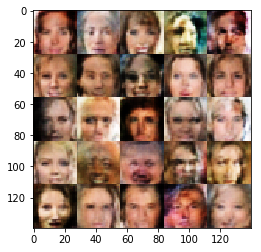

Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.8352
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 2.1458
Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 2.3829
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 1.6369
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 1.9945
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 3.3402... Generator Loss: 0.0601
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 2.3772
Epoch 1/1... Discriminator Loss: 0.2499... Generator Loss: 2.6743
Epoch 1/1... Discriminator Loss: 0.1344... Generator Loss: 4.0263


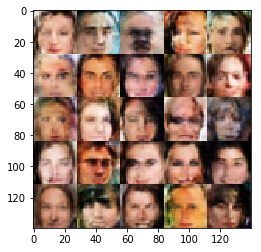

Epoch 1/1... Discriminator Loss: 0.1461... Generator Loss: 3.2249
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 6.9325
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 0.2969... Generator Loss: 3.5421
Epoch 1/1... Discriminator Loss: 0.3040... Generator Loss: 1.9307
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 5.5906
Epoch 1/1... Discriminator Loss: 0.2486... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 2.9501
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 2.8927
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 2.5482


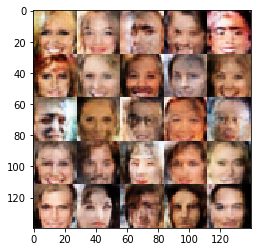

Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 2.0148
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 2.9349
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 4.1459
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 3.9186
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 5.7937
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 2.4839
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 2.4302
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 1.2203


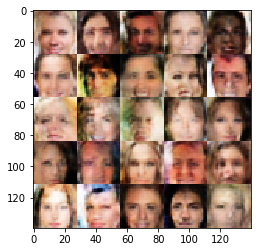

Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 2.1515
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 4.2947
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 2.3166
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 4.4868
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 1.8345


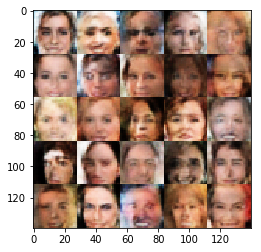

Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 2.7570
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 2.7375
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 3.0655
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 1.6930
Epoch 1/1... Discriminator Loss: 0.1077... Generator Loss: 3.1312
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 10.2970
Epoch 1/1... Discriminator Loss: 0.2194... Generator Loss: 1.9791
Epoch 1/1... Discriminator Loss: 2.3025... Generator Loss: 4.2819


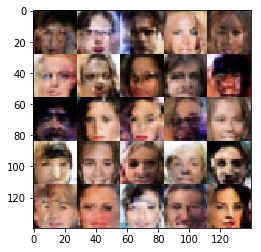

Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 1.6792
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 1.9033
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 0.0556... Generator Loss: 4.0931
Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 4.3392
Epoch 1/1... Discriminator Loss: 0.1705... Generator Loss: 2.2575
Epoch 1/1... Discriminator Loss: 0.2972... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 0.9440


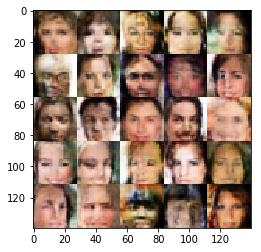

Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 4.3622
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 1.7139
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 1.9094
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 5.0887
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 1.5459
Epoch 1/1... Discriminator Loss: 0.2802... Generator Loss: 2.0357


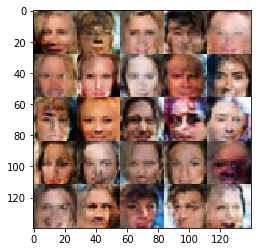

Epoch 1/1... Discriminator Loss: 0.1465... Generator Loss: 3.8402
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 3.0434
Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 4.2872
Epoch 1/1... Discriminator Loss: 0.0359... Generator Loss: 7.0466
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 3.5922
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 1.9977
Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 2.8848
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.3448


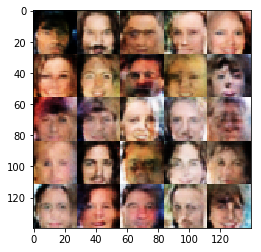

Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 3.0573
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 0.1000... Generator Loss: 4.2409
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 7.0259
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 4.7631


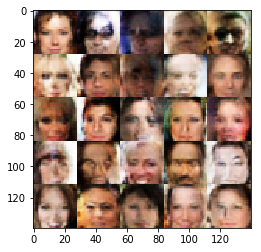

Epoch 1/1... Discriminator Loss: 0.3157... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 1.5957
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 3.2492
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 3.4122
Epoch 1/1... Discriminator Loss: 2.5674... Generator Loss: 0.1324
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 2.3485


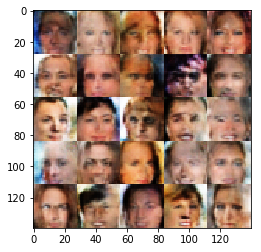

Epoch 1/1... Discriminator Loss: 0.1964... Generator Loss: 2.7769
Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 3.4024
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.2328... Generator Loss: 2.1494
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 3.9009
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 2.8559
Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 2.9316
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 3.5404
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 1.2653


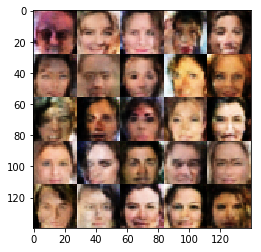

Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 3.0057
Epoch 1/1... Discriminator Loss: 0.1315... Generator Loss: 5.1026
Epoch 1/1... Discriminator Loss: 0.1504... Generator Loss: 3.1811
Epoch 1/1... Discriminator Loss: 0.1703... Generator Loss: 2.4968
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 4.6473
Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 4.3793
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 10.5935


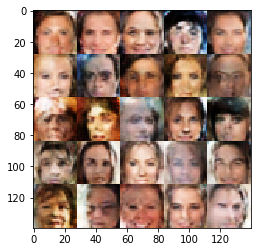

Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 2.8471
Epoch 1/1... Discriminator Loss: 0.1168... Generator Loss: 2.8083
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 3.7043
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 4.2911
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 1.9301
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 3.2478
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 4.0371
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 1.4059


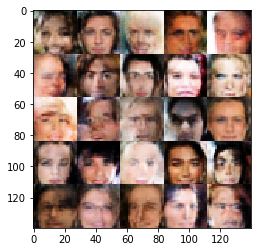

Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.2374
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 1.5662


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.